In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

In [4]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Importation des datasets

In [5]:
cities = pd.read_csv("/content/drive/MyDrive/DaSci/Test Stage/Data/data/cities.csv", sep=",")
providers = pd.read_csv("/content/drive/MyDrive/DaSci/Test Stage/Data/data/providers.csv", sep=",")
stations = pd.read_csv("/content/drive/MyDrive/DaSci/Test Stage/Data/data/stations.csv", sep=",")
ticket_data = pd.read_csv("/content/drive/MyDrive/DaSci/Test Stage/Data/data/ticket_data.csv", sep=",")

In [6]:
ticket_data.head()

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542


# I/ Global Analysis

La première partie de se rapport a pour but de faire une analyse gloable des données :  on va déterminer le prix min, moyen et max, ainsi que la durée min/max/moyenne par trajet


### a) Price analysis

On accède facilement à mean, max et min de price avec la fonction describe()

In [ ]:
ticket_data['price_in_cents'].describe()

count    74168.000000
mean      4382.711061
std       3739.325367
min        300.000000
25%       1900.000000
50%       3350.000000
75%       5250.000000
max      38550.000000
Name: price_in_cents, dtype: float64

On peut voir que le prix moyen d'un ticket chez TicTactrip est de 4382 cents (soit 43,82€), le prix maximum est de 38 550 cents (soit 385,5€), et le prix minimum de 300 cents (soit 3€). 

Ces valeurs sont basées sur un échatillon de 74 168 tickets. 

Text(0.5, 1.0, 'Distribution of tickets price')

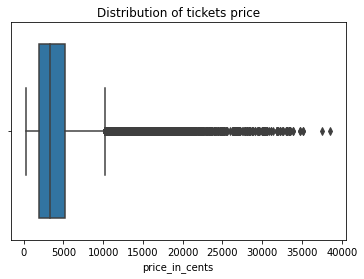

In [ ]:
sns.boxplot(x="price_in_cents", data=ticket_data).set_title("Distribution of tickets price")

En représentant la répartition des prix avec une boxplot, on observe que 75% des prix sont compris entre 3€ et 52,50€. 

Les prix supérieurs à la centaine d'euros représentent une minorité des achats sur cette plateforme. 

### b) Analysis of journey times

On veut maintenant déterminer la durée moyenne d'un trajet ainsi que son min et son max. <br/>
Pour faciliter les choses, je crée une nouvelle colonne "duration_hours" qui correspond à la durée du trajet, c'est à dire le temps pris pour aller de "departure_ts" à "arrival_ts". Cette durée est représenté en heures. 

#### Création d'une colonne durée

In [7]:
from datetime import datetime
from datetime import timedelta

durations = []
for k in range(74168):
  #On retire le +00 qui nous embête dans les colonnes departure et arrival
  departure = ticket_data['departure_ts'][k][:len(ticket_data['departure_ts'][k])-3]
  arrival = ticket_data['arrival_ts'][k][:len(ticket_data['arrival_ts'][k])-3]
  
  #On convertie les données en datatime
  departure_dt = datetime.strptime(departure, '%Y-%m-%d %H:%M:%S')
  arrival_dt = datetime.strptime(arrival, '%Y-%m-%d %H:%M:%S')

  #On fait la différence des deux pour avoir la durée
  time_delta = (departure_dt - arrival_dt)
  total_seconds = time_delta.total_seconds() #durée en secondes
  hours = round(total_seconds/3600,2)
  durations.append(abs(hours))

ticket_data['duration_hours'] = durations


In [30]:
ticket_data.head()

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,duration_hours
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542,6.17
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,17.83
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542,31.95
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542,21.58
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542,21.77


#### Analyse

On peut maintenant facilement déterminer la durée moyenne, le max et le min avec la fonction describe

In [ ]:
ticket_data['duration_hours'].describe()

count    74168.000000
mean         7.076948
std          9.916370
min          0.330000
25%          3.000000
50%          4.830000
75%          8.000000
max        492.850000
Name: duration_hours, dtype: float64

On peut voir que la durée moyenne d'un trajet sur cet échantillon de données  est de 7 heures, la durée maximale est de 492 heures (soit 20,5 jours) et la durée minimale de 0.33 heures (soit 19 minutes). 

75 % des trajets ont une durée inférieure à 8 heures. La représentation sous forme de boxplot donne le résultat suivant : 


Text(0.5, 1.0, 'Distribution of travel time')

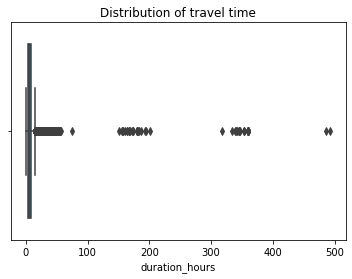

In [ ]:
sns.boxplot(x="duration_hours", data=ticket_data).set_title("Distribution of travel time")


Si la très grande majorité des trajets ont une durée inférieure à 8 heures, on observe des clusters avec des durées beaucoup plus importantes : il y a un cluster autour de 40 heures, de 180 heures, et de 350 heures

# II/ Différence de prix selon le type de transport et la distance

Dans cette deuxième partie, nous allons déterminer le prix des trajets selon le type de transport et la distance. 

### a) Différence de prix selon le type de transport

On souhaite déterminer la différence de prix selon le type de transport. Dans la table "ticket_data", nous ne disposons pas de la catégorie de transport. Nous allons devoir créer une nouvelle colonne "transport_type" que l'on crée en faisant une sorte de jointure entre les tables "ticket_data" et "providers". 

En effet, la colonne ticket_data['company'], nous permet de faire le lien avec la table providers qui nous la catégorie de chaque transport

#### Création colonne transport_type

In [8]:
transport = []
for k in range(74168):
  entreprise_id = ticket_data['company'][k] #on récupère le compagny_id
  transport.append(str(providers[providers['id'] == entreprise_id]['transport_type']).split()[1]) #on fait le lien avec la table providers.csv (split nous permet de nous débarasser des termes inutiles)

ticket_data['transport_type'] = transport

In [9]:
ticket_data.head()

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,transport_type
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542,carpooling
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,bus
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542,train
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542,train
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542,train


#### Visualisation des prix en fonction du type de transport

Maintenant que nous avons créé la catégorie "transport_type", nous pouvons facilement visualiser la répartition des prix en fonction des types de transport. On reoprensente le boxplot suivant : 

Text(0.5, 1.0, 'Répartition des prix en fonction du type de transport')

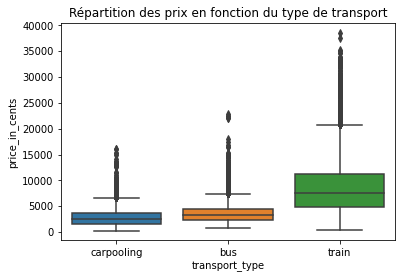

In [36]:
sns.boxplot(data=ticket_data, x='transport_type', y='price_in_cents').set_title("Répartition des prix en fonction du type de transport")

On peut observer que le mode de transport le moins cher est le covoiturage (carpooling), puis vient le bus et train est le mode de trasnport le plus cher. 

On constate également que plus le prix moyen est important, plus la répartition des prix est inégale : on retrouve ainsi dans les 3 cas un prix minimum similaire (de 3€ pour le covoiturage, 8,5€ pour le bus et 4,90€ pour le train) mais un prix maximum de 385€ pour le train, 229€ pour le bus et 361€ pour le covoiturage. 

Ces valeurs sont obtenues avec le code suivant : 

In [50]:
#liste des types de transport
transport_type = ['carpooling', 'bus', 'train']

#On print les caractéritiques des prix de ces différents moyen de transport
for transport in transport_type: 
  print('========================================')
  print('la répartition des prix pour le', transport)
  print(ticket_data[ticket_data['transport_type']== transport ]['price_in_cents'].describe())

la répartition des prix pour le carpooling
count    41441.000000
mean      2742.171907
std       1501.934054
min        300.000000
25%       1550.000000
50%       2500.000000
75%       3600.000000
max      16150.000000
Name: price_in_cents, dtype: float64
la répartition des prix pour le bus
count    13798.000000
mean      3652.448036
std       1913.197779
min        850.000000
25%       2390.000000
50%       3300.000000
75%       4400.000000
max      22900.000000
Name: price_in_cents, dtype: float64
la répartition des prix pour le train
count    18929.000000
mean      8506.634793
std       4888.064503
min        490.000000
25%       4800.000000
50%       7540.000000
75%      11200.000000
max      38550.000000
Name: price_in_cents, dtype: float64


Les chiffres intéressants sont : 
- Covoiturage : 
  - moyenne : 25€
  - min : 3€
  - max : 161€

- Bus : 
  - moyenne : 33€
  - min : 8,5€
  - max : 229€

- Train : 
  - moyenne : 75€
  - min : 4,9€
  - max : 385€

Avant de passer à la suite, je trouvais intéressant de regarder la proportion de ces 3 différents mode de transport sur TicTacTrip et le pourcentage du Chiffre d'affaire (CA) pour chacun des types de transport. On obtient le graphe suivant : 

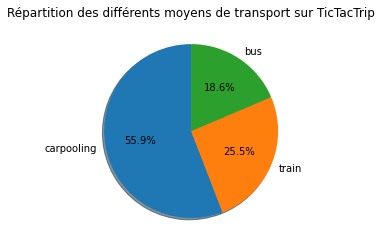

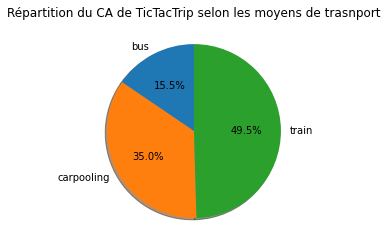

In [81]:
#Répartition des différents moyens de transport sur TicTacTrip
transport_type = ['carpooling', 'train', 'bus']
proportion = ticket_data['transport_type'].value_counts() #détermine le nombre de chaque catégorie


fig1, ax1 = plt.subplots()
ax1.pie(proportion, labels=transport_type, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.title('Répartition des différents moyens de transport sur TicTacTrip')
plt.show()


#Répartition des différents moyens de transport sur TicTacTrip
transport_type_2 = ['bus', 'carpooling', 'train']
CA_type = ticket_data.groupby("transport_type")["price_in_cents"].sum() #détermine le CA selon chaque catégorie


fig1, ax1 = plt.subplots()
ax1.pie(CA_type, labels=transport_type_2, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.title('Répartition du CA de TicTacTrip selon les moyens de trasnport')
plt.show()

Il est interessant de constater que le covoiturage est le moyen de transport le plus utilisé, vient ensuite le train puis le bus. Bien que le train ne représente que 25% des trajets, il représente près de 50% du chiffre d'affaire.

### b) Différence de prix selon la distance parcourue

On veut ensuite déterminer le prix en fonction de la distance parcourue. Nous ne disposons pas de la distance parcourue mais seulement de la ville d'origine (avec "o_city") et la ville d'arrivée ("d_city). 

Connaissant les coordonnées géographique des villes en question avec la table cities.csv, on peut déterminer la distance du trajet. 

Nous allons, en suivant cette technique, créer une nouvelle colonne "distance" qui correspond à la distance à vol d'oiseau entre les deux villes du trajet. 

#### Création colonne distance

Nous voulons ici déterminer la distance entre deux villes en utilisant les coordonnées latitude-longitude.

Pour cela, nous allons utiliser la formule de Haversine. Cette formule tient compte de la courbure de la Terre. Elle est alors beaucoup plus précise que des formule de distance traditionelle. 

La fonction "distance"  suivante permet de mesurer la distance entre deux villes ("origin_city" et "destination_city"), en utilisant la formule Haversine. 


In [9]:
import math

def distance(origin_city, destination_city): 
  #radius of the Earth
  R = 6373.0

  #coordinates
  lat1 = math.radians(cities[cities['id'] == origin_city]['latitude'])
  lon1 = math.radians(cities[cities['id'] == origin_city]['longitude'])
  lat2 = math.radians(cities[cities['id'] == destination_city]['latitude'])
  lon2 = math.radians(cities[cities['id'] == destination_city]['longitude'])

  #change in coordinates
  dlon = lon2 - lon1
  dlat = lat2 - lat1

  #Haversine formula
  a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2

  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
  distance = R * c
  return distance

Une fois que nous avons écrit cette fonction "distance", on peut facilement faire une nouvelle colonne "distance_km". 

La jointure entre les tables cities.csv et ticket_data.csv se fait avec ticket_data['o_city'] = cities[id]

In [10]:
distance_trajets = []

for k in range(74168): 
  origin_city = ticket_data['o_city'][k]
  destination_city = ticket_data['d_city'][k]
  d = distance(origin_city, destination_city)
  distance_trajets.append(d)

ticket_data['distance_km'] = distance_trajets

In [30]:
ticket_data.head()

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,transport_type,distance_km
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542,carpooling,503.355132
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,bus,503.355132
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542,train,503.355132
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542,train,503.355132
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542,train,503.355132


Maintenant que nous avons créé la colonne distance on peut s'amuser à regarder la répartition de la distance en km de ces différents trajets. On obtient le boxplot suivant :

count    74168.000000
mean       363.152147
std        194.991807
min         18.919179
25%        205.907209
50%        338.426341
75%        480.564632
max       1870.759110
Name: distance_km, dtype: float64

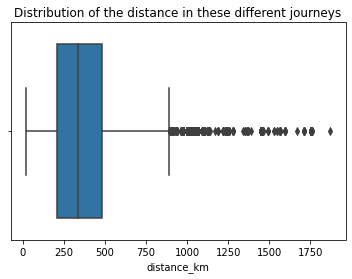

In [79]:
sns.boxplot(x="distance_km", data=ticket_data).set_title("Distribution of the distance in these different journeys")
ticket_data['distance_km'].describe()

Il est interessant de constater que la distance moyenne parcourue est de 363km, la distance minimale est de 18km et la distance maximale de 1870km.

#### Création d'une colonne catégorie_distance

Dans cette exercice, on veut déterminer le prix en fonction de 4 catégories de distance du trajet : 0-200km, 201-800km, 800-2000km et 2000+km. 

Nous devons alors créer une nouvelle colonne "categorie_distance" qui regroupe les distances dans une des quatre catégorie donnée ci-dessus. 

In [40]:
categorie_distance = []

for k in range(74168): 
  if ticket_data['distance_km'][k]<=200: 
    categorie_distance.append('0-200km')
  elif 200 < ticket_data['distance_km'][k]<=800: 
    categorie_distance.append('201-800km')
  elif 800 < ticket_data['distance_km'][k]<=2000: 
    categorie_distance.append('800-2000km')
  else: 
    categorie_distance.append('2000+km')

ticket_data['categorie_distance'] = categorie_distance 

In [41]:
ticket_data.head()

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,transport_type,distance_km,categorie_distance
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542,carpooling,503.355132,201-800km
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,bus,503.355132,201-800km
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542,train,503.355132,201-800km
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542,train,503.355132,201-800km
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542,train,503.355132,201-800km


###  Répartition des prix en fonction de la catégorie_distance 

Ayant créé la colonne "categorie_distance", on peut représenter facilement la la différence de prix moyen selon la distance du trajet ((0-200km, 201-800km, 800-2000km, 2000+km). On obtient le résultat suivant : 



Text(0.5, 1.0, 'Répartition des prix en fonction de la distance')

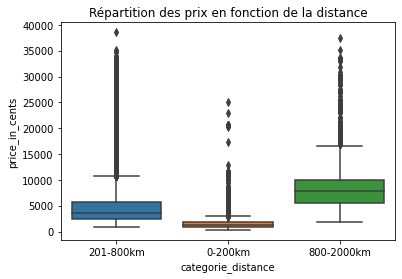

In [43]:
sns.boxplot(data=ticket_data, x='categorie_distance', y='price_in_cents').set_title("Répartition des prix en fonction de la distance")

In [44]:
#liste des types de catégorie de distance
category_distance = ['0-200km', '201-800km', '800-2000km']

#On print les caractéritiques des prix de ces différents moyen de transport
for distance in category_distance: 
  print('========================================')
  print('la répartition des prix pour le categorie', distance, ' est:"')
  print(ticket_data[ticket_data['categorie_distance']== distance]['price_in_cents'].describe())

la répartition des prix pour le categorie 0-200km  est:"
count    13724.000000
mean      1678.972311
std       1340.887966
min        300.000000
25%        950.000000
50%       1300.000000
75%       1800.000000
max      25100.000000
Name: price_in_cents, dtype: float64
la répartition des prix pour le categorie 201-800km  est:"
count    58877.000000
mean      4893.836592
std       3745.577272
min        850.000000
25%       2500.000000
50%       3600.000000
75%       5800.000000
max      38550.000000
Name: price_in_cents, dtype: float64
la répartition des prix pour le categorie 800-2000km  est:"
count     1567.000000
mean      8857.869177
std       5008.885867
min       1940.000000
25%       5500.000000
50%       7780.000000
75%      10050.000000
max      37550.000000
Name: price_in_cents, dtype: float64


Sans surprise, on constate que plus la distance est élevée, plus le prix est élevée. 

On constate que le prix moyen pour la catégorie "0-200km" est de 16,78€, pour la catégorie "201-800km" de 48,93€ et pour la catégorie "800-2000km" est de 88,57€. 

#### Répartition des categorie_distance

Avant de terminer je trouvais intéressant de regarder la proportion de ces 3 catégories. On obtient le boxplot suivant : 

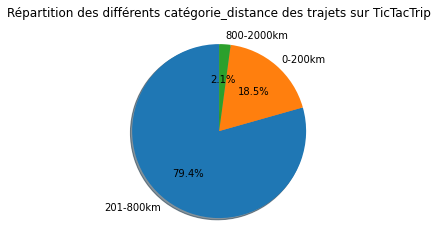

In [47]:
#Répartition des différents moyens de transport sur TicTacTrip
category_distance2 = ['201-800km','0-200km', '800-2000km']
proportion = ticket_data['categorie_distance'].value_counts() #détermine le nombre de chaque catégorie


fig1, ax1 = plt.subplots()
ax1.pie(proportion, labels=category_distance2, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.title('Répartition des différents catégorie_distance des trajets sur TicTacTrip')
plt.show()

Il est interessant de constater que les trajets de 200-800km représente la très grosse majorité des trajets sur la plateforme avec près de 80% des trajets totaux



# III/ Analyses supplémentaires

De nombreuses données n'ont pas été exploitées dans la table providers.csv. Dans cette partie nous allons essayer de les exploiter pour extraire des informations supplémentaires. 

On va ici créer une nouvelle table, appelée data_ML qui va être utilisé pour les parties III et IV

In [13]:
#On crée une nouvelle table que nous allons utilisé pour le Machine Learning
data_ML = ticket_data[['company', 'duration_hours', 'distance_km','transport_type','price_in_cents']]
data_ML.head()

,company,duration_hours,distance_km,transport_type,price_in_cents
0,8385,6.17,503.355132,carpooling,4550
1,9,17.83,503.355132,bus,1450
2,8377,31.95,503.355132,train,7400
3,8377,21.58,503.355132,train,13500
4,8381,21.77,503.355132,train,7710


### a) Etude des gadgets sur le prix du billet

#### Création d'une nouvelle table

Dans cette partie, nous allons étudier la répartition du prix des billets en fonction des gadgets du trajet (wifi, plug, bicycle) et de la compagnie.

On va alors extraire ces données de la table providers.csv de la même manière que pour extraire la catégorie de transport. 

On ajoute toutefois une petite différence : on convertie toutes les valeurs True et False par des valeurs binaires 1 ou 0 avec la fonction has_an_element suivante : 

In [11]:
#On définie une fonction simple qui convertie les String "True" et "False" en valeurs binaires 0 et 1
def has_an_element(element):
  if element == 'True' : 
    return 1
  elif element == 'False': 
    return 0

On réalise maintenant l'extraction des colonnes qui nous interessent

In [ ]:
name = []
wifi = []
plug = []
adjustable_seat = []
bicycle = []

for k in range(74168):
  #on récupère le compagny_id dans la table ticket_data
  entreprise_id = ticket_data['company'][k] 

  #On ajoute à chaque ligne k les informations : name_company, has_wifi, has_plug, has_adjustable_seats, has_bicycle
  name.append(str(providers[providers['id'] == entreprise_id]['fullname']).split()[1])  #on ajoute à la liste name le nom de l'entreprise concernée pour le ticket k
  wifi.append(has_an_element(str(providers[providers['id'] == entreprise_id]['has_wifi']).split()[1])) #on ajoute 1 à la liste wifi si le ticket k a de la wifi, 0 sinon
  plug.append(has_an_element(str(providers[providers['id'] == entreprise_id]['has_plug']).split()[1])) #on ajoute 1 à la liste plug si le ticket k a du plog, 0 sinon
  adjustable_seat.append(has_an_element(str(providers[providers['id'] == entreprise_id]['has_adjustable_seats']).split()[1])) #on ajoute 1 à la liste adjustable_seat si le ticket k a un siège ajustable, 0 sinon
  bicycle.append(has_an_element(str(providers[providers['id'] == entreprise_id]['has_bicycle']).split()[1])) #on ajoute 1 à la liste bicylce si le ticket k peut contenir des vélos, 0 sinon

data_ML['name_company'] = name
data_ML['has_wifi'] = wifi
data_ML['has_plug'] = plug
data_ML['has_adjustable_seat'] = adjustable_seat
data_ML['has_bicycle'] = bicycle

On obtient alors le dataset suivant nous permettant facilement de faire des représentations graphiques. 

In [15]:
data_ML.head()

,company,duration_hours,distance_km,transport_type,price_in_cents,name_company,has_wifi,has_plug,has_adjustable_seat,has_bicycle
0,8385,6.17,503.355132,carpooling,4550,Blablacar,0.0,0.0,0.0,0.0
1,9,17.83,503.355132,bus,1450,Ouibus,1.0,1.0,1.0,0.0
2,8377,31.95,503.355132,train,7400,Intercités,0.0,0.0,1.0,0.0
3,8377,21.58,503.355132,train,13500,Intercités,0.0,0.0,1.0,0.0
4,8381,21.77,503.355132,train,7710,Intercités,0.0,0.0,1.0,0.0


#### Répartition des prix en fonction des compagnies

On représente d'abord le prix en fonction des compagnies. On constate que les compagnies les plus chères sont les compagnies de train vers l'étranger (thalys et Eurostar) et les compagnies les moins chères sont les compagnies de covoiturage avec notamment Blablacar. 

On remarque également que TGV et Eurostar sont les compagnies avec l'écart type le plus élevé (autrement dit avec les prix les plus éparpillé).

Text(0.5, 1.0, 'Répartition des prix en fonction des compagnies')

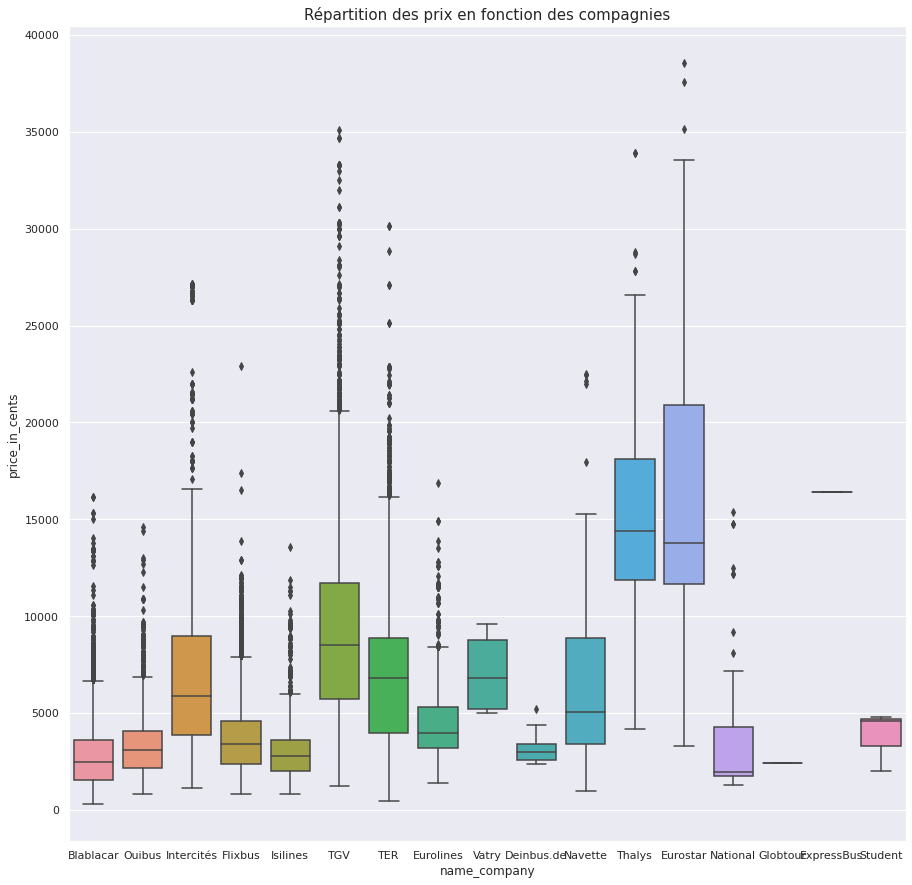

In [168]:
plt.figure(figsize=(15, 15))
sns.boxplot(data=data_ML, x='name_company', y='price_in_cents').set_title("Répartition des prix en fonction des compagnies" , fontsize=15)
  

#### Répartition des prix en fonction des gadgets

On peut également étudier l'influence des différents gadgets sur le prix du billet. De la même manière, on obtient les graphes suivants : 

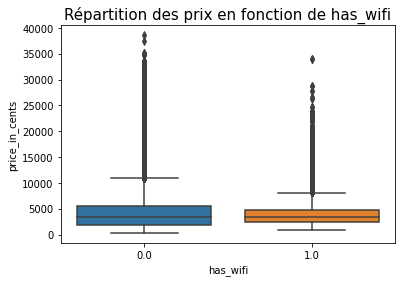

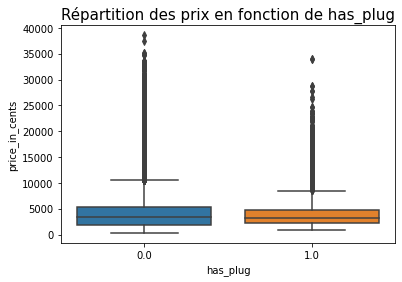

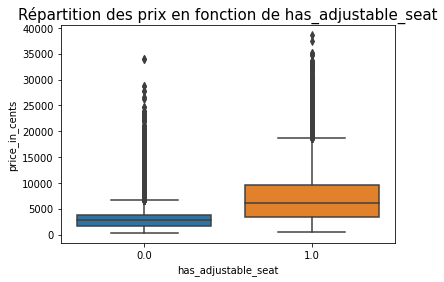

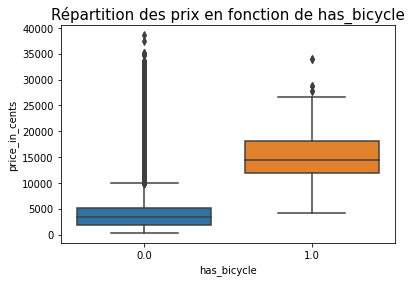

In [116]:
list = ['has_wifi',	'has_plug',	'has_adjustable_seat',	'has_bicycle']

for element in list: 
  sns.boxplot(data=data_ML, x=element, y='price_in_cents').set_title("Répartition des prix en fonction de " + element, fontsize=15)
  plt.show()

On constate que si la wifi et le plug n'ont pas trop d'influence sur le prix, le fait d'avoir des sièges ajustables ou la possibilité de prendre un vélo augmente considérablement le prix. 

#### b) Etude de l'évolution des prix en fonction des mois, années et heures. 

Je considerais qu'il était intéressant de faire une analyse temporelle des prix et d'étudier les prix en fonction du temps. 

J'ai pour cela créé 4 nouvelles colonnes "year", "month", "day" et "hour" de la même manière que précédement. On fait de la manière suivante : 

#### Création des colonnes year, month, day, hour

In [ ]:
years = []
months = []
days = []
hours = []


for k in range(74168):
  years.append(int(ticket_data['departure_ts'][k][:4])) #on ajoute l'année sous forme int
  months.append(int(ticket_data['departure_ts'][k][5:7])) #on ajoute le mois
  days.append(int(ticket_data['departure_ts'][k][8:10])) #on ajoute le jour
  hours.append(int(ticket_data['departure_ts'][k][11:13])) #on ajoute l'heure

data_ML['year'] = years
data_ML['month'] = months
data_ML['day'] = days
data_ML['hour'] = hours

In [13]:
data_ML.head()

,company,duration_hours,distance_km,transport_type,price_in_cents,name_company,has_wifi,has_plug,has_adjustable_seat,has_bicycle,year,month,day,hour
0,8385,6.17,503.355132,carpooling,4550,Blablacar,0.0,0.0,0.0,0.0,2017,10,13,14
1,9,17.83,503.355132,bus,1450,Ouibus,1.0,1.0,1.0,0.0,2017,10,13,13
2,8377,31.95,503.355132,train,7400,Intercités,0.0,0.0,1.0,0.0,2017,10,13,13
3,8377,21.58,503.355132,train,13500,Intercités,0.0,0.0,1.0,0.0,2017,10,13,13
4,8381,21.77,503.355132,train,7710,Intercités,0.0,0.0,1.0,0.0,2017,10,13,21


#### Visualisation

Tout d'abord, il aurait été intéressant d'étudier l'évolution des prix au cours des dernières années pour voir s'il y a une évolution significative des prix ainsi que l'évolution des prix sur une année (évolution sur au cours des mois) pour voir si on peut observer des saisonalités. 

Cependant, nous avons des données seulement pour l'année 2017 et principalemennt pour le mois d'octobre (mois 10), comme le montre le graphe ci-dessous. De telles ananlyses ne peuvent alors être effectuées... 

In [151]:
print('=======================================')
print('Répartition des mois dans le dataset étudié :')
print(data_ML['month'].value_counts())

print('=======================================')
print('Répartition des années dans le dataset étudié :')
print(data_ML['year'].value_counts())

Répartition des mois dans le dataset étudié :
10    69907
11     2969
12      881
9       254
1       100
2        30
3        27
Name: month, dtype: int64
Répartition des années dans le dataset étudié :
2017    74011
2018      157
Name: year, dtype: int64


On peut toutefois faire une représentation temporelle des données qu'on possède. On obtient le résultat suivant : 

#### Réprésentation temporelle

Text(0, 0.5, 'price (cents)')

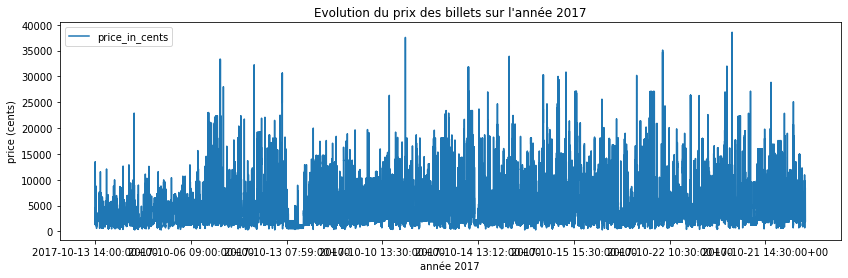

In [155]:
#On trie les données par ordre c
ticket_data.sort_values('departure_ts')
ticket_data.plot(x="departure_ts", y="price_in_cents", figsize=(14,4))
plt.title("Evolution du prix des billets sur l'année 2017")
plt.xlabel("année 2017")
plt.ylabel("price (cents)")


On remarque une légère augmentation du prix entre le début et la fin de l'année 2017

#### Nombre de trajets par mois

Text(0.5, 1.0, "Nombre de trajets ayant eu lieu sur le mois d'octobre 2017")

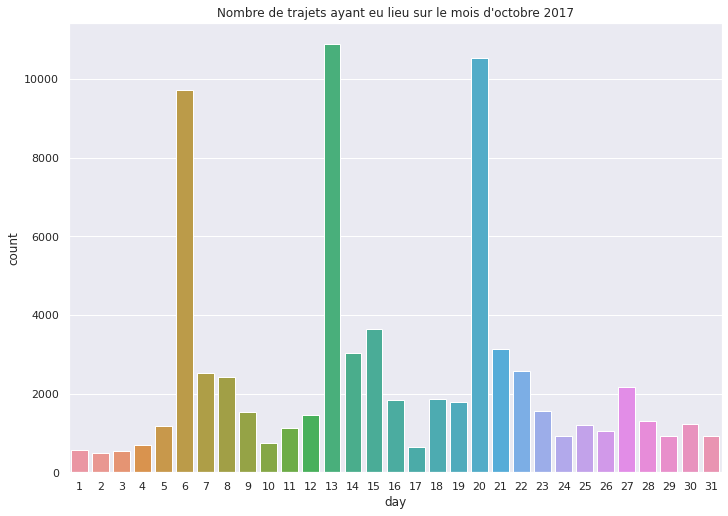

In [164]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x='day', data=data_ML).set_title("Nombre de trajets ayant eu lieu sur le mois d'octobre 2017")

Il est interessant de constater qu'on observe 3 pics le 6, 13 et 20 octobre, qui correspondent tous 3 à des vendredi. Cela est cohérent car lors des départs en weekend, les gens ont plus tendance à faire des trajets longs. 

On remarque une saisonalité par semaine : il y a un pic le vendredi et plus de départs le samedi, dimanche et lundi qu'en semaine

#### Nombre de trajet par heure

Text(0.5, 1.0, 'Nombre de trajets ayant eu lieu sur une journée en octobre 2017')

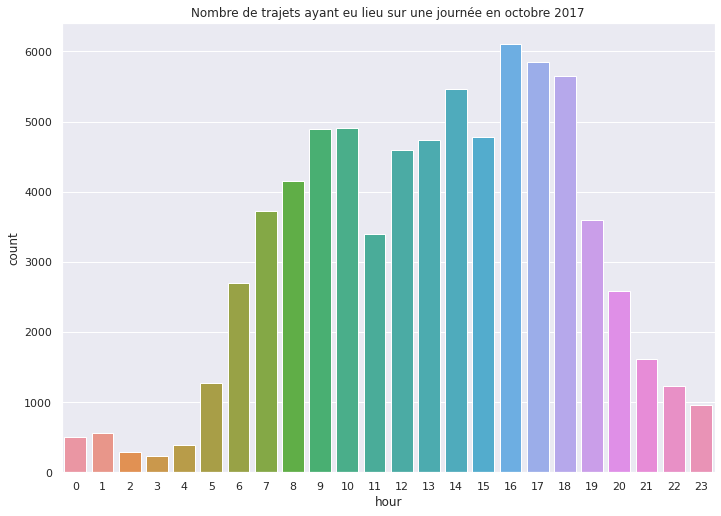

In [167]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x='hour', data=data_ML).set_title("Nombre de trajets ayant eu lieu sur une journée en octobre 2017")

Text(0.5, 1.0, "Répartition des prix en fonction de l'heure de la journée")

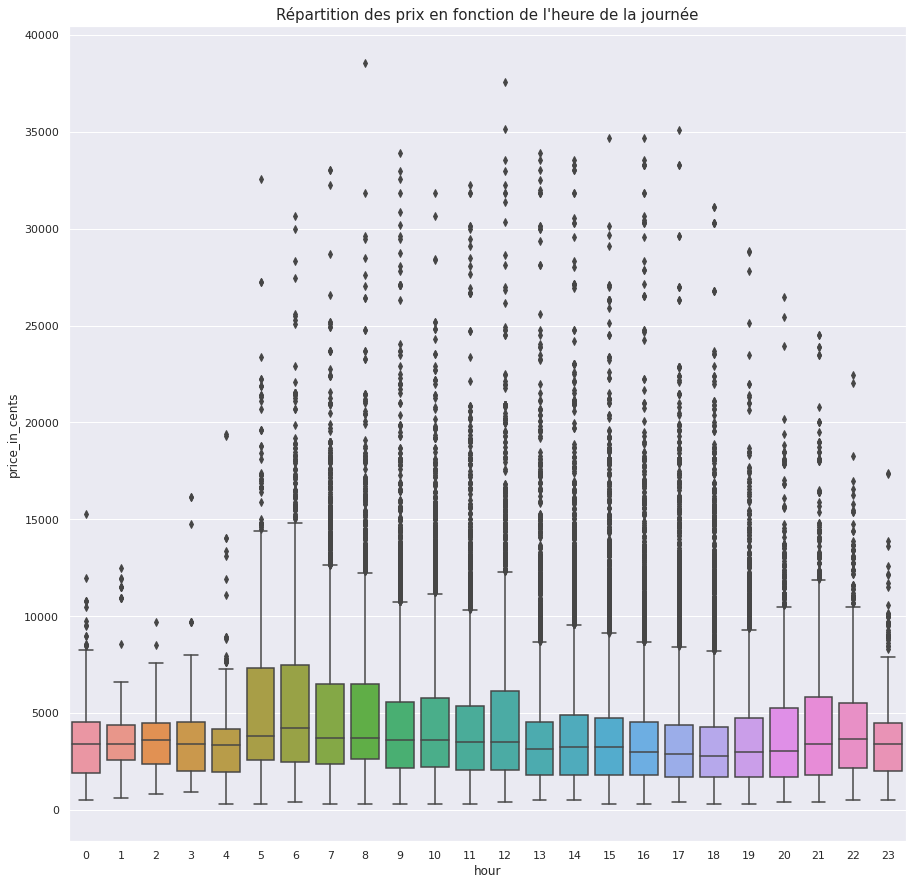

In [172]:
plt.figure(figsize=(15, 15))
sns.boxplot(data=data_ML, x='hour', y='price_in_cents').set_title("Répartition des prix en fonction de l'heure de la journée", fontsize=15)

Si le prix moyen à l'heure ne varie pas trop sur une journée, on peut constater que ce prix est beaucoup plus variable (écart type beaucoup plus important) pour des trajets de journée que de nuit

# IV/ Machine learning

Dans cette dernière partie, nous voulons appliquer des algorithmes de Machine Learning au jeu de données pour prédire le prix des billets en fonction de différents features. 

### a) Préparation

#### Préparation des données pour le Machine Learning

Nous avons peu de valeurs pour le mois et l'année. On supprime alors ces colonnes pour le Machine Learning. La nouvelle expression de data_ML, tableau sur lequel nous allons traiter les données est donc : 

In [17]:
data_ML = data_ML.drop(['company', 'month', 'year'], axis=1)
data_ML

,duration_hours,distance_km,transport_type,price_in_cents,name_company,has_wifi,has_plug,has_adjustable_seat,has_bicycle,day,hour
0,6.17,503.355132,carpooling,4550,Blablacar,0.0,0.0,0.0,0.0,13,14
1,17.83,503.355132,bus,1450,Ouibus,1.0,1.0,1.0,0.0,13,13
2,31.95,503.355132,train,7400,Intercités,0.0,0.0,1.0,0.0,13,13
3,21.58,503.355132,train,13500,Intercités,0.0,0.0,1.0,0.0,13,13
4,21.77,503.355132,train,7710,Intercités,0.0,0.0,1.0,0.0,13,21
...,...,...,...,...,...,...,...,...,...,...,...
74163,13.50,338.426341,bus,2590,Flixbus,1.0,0.0,0.0,0.0,27,2
74164,6.50,338.426341,bus,2700,Ouibus,1.0,1.0,1.0,0.0,27,7
74165,6.75,338.426341,bus,3000,Isilines,1.0,1.0,1.0,0.0,27,8
74166,7.75,338.426341,bus,2880,Flixbus,1.0,0.0,0.0,0.0,27,13


Nous voulons appliquer des algorithmes de machine learning aux données suivantes pour essayer de prédire le prix des billets en fonction du type de trasnport, de la distance, de la durée, de la compagnie et des gadgets. 

Toutefois, pour appliquer des algorithmes de Machine Learning nous devons transformer tous les string en float. On applique alors un One Encoding pour encoder tous les strings sous une forme binaire. 

De plus, il faut penser à enlever les quelques lignes avec des valeurs manquantes. 

On obtient alors : 

In [18]:
#One Hot Encoding
df = pd.get_dummies(data_ML)

#On enleve les lignes NaN
df = df.dropna()
df

,duration_hours,distance_km,price_in_cents,has_wifi,has_plug,has_adjustable_seat,has_bicycle,day,hour,transport_type_bus,transport_type_carpooling,transport_type_train,name_company_Blablacar,name_company_Deinbus.de,name_company_Eurolines,name_company_Eurostar,name_company_ExpressBus,name_company_Flixbus,name_company_Globtour,name_company_Intercités,name_company_Isilines,name_company_National,name_company_Navette,name_company_Ouibus,name_company_Student,name_company_TER,name_company_TGV,name_company_Thalys,name_company_Vatry
0,6.17,503.355132,4550,0.0,0.0,0.0,0.0,13,14,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,17.83,503.355132,1450,1.0,1.0,1.0,0.0,13,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,31.95,503.355132,7400,0.0,0.0,1.0,0.0,13,13,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,21.58,503.355132,13500,0.0,0.0,1.0,0.0,13,13,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,21.77,503.355132,7710,0.0,0.0,1.0,0.0,13,21,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74163,13.50,338.426341,2590,1.0,0.0,0.0,0.0,27,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
74164,6.50,338.426341,2700,1.0,1.0,1.0,0.0,27,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
74165,6.75,338.426341,3000,1.0,1.0,1.0,0.0,27,8,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
74166,7.75,338.426341,2880,1.0,0.0,0.0,0.0,27,13,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


#### Définition des features et du label

Nous voulons ici essayer de prédire le prix des billets en fonction du type de trasnport, de la distance, de la durée, de la compagnie et des gadgets.

Ainsi nos features (qui correspondent à X) sont : duration_hours,	distance_km, has_wifi,	has_plug,	has_adjustable_seat,	has_bicycle,	day,	hour,	transport_type et name_company. 

Le label (qui correspond à y) est price_in_cents

In [19]:
#X correspond au features
X = df.drop(['price_in_cents'], axis=1)

#y correspond au label, la 
y = df['price_in_cents']


### b) Application des algorithmes de Machine Learning au dataset

#### Choix de Kfold au lieu d'un classique train_test_split

Pour améliorer la précision des différents algorithmee de prédiction que je vais utiliser, et éviter en particulier un surapprentissage, j'ai entrainé l'ensemble de mes algorithmes supervisés sur une validation croisée, en utilisant Kfold de la librairie sklearn. 

Cette technique consiste à diviser l'échantillon original en k échantillons, à sélectionner un de ces k échantillons comme ensemble de validation pendant que les k-1 autres échantillons constituent l'ensemble d'apprentissage. 

Cette méthode est bien plus précise qu'une division binaire du dataset en une partie d'apprentissage et une seconde de prédiction. 

Ici, j'ai choisi de diviser le dataset en 10 parties. 

#### DecisionTree

Dans une première partie, j'ai voulu prédire le prix des billets avec un DécisionTree. 

J'ai fait varié l'hyperparamètre max_depth lors de la période d'apprentissage

In [22]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
RANDOM_SEED = 45 #graine aléatoire


def arbre_de_decision(X,y,n_split=10,max_depth=10):
    kf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_SEED)
    r2_scores_by_depth = []
    for i in range(max_depth):
        r2_scores = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            tree_reg = DecisionTreeRegressor(max_depth=i+1)
            tree_reg.fit(X_train,y_train)
            y_pred = tree_reg.predict(X_test)
            r2_scores.append(r2_score(y_test,y_pred))
        r2_scores_by_depth.append(np.mean(r2_scores))
    plt.plot(r2_scores_by_depth)
    print("On obtient une meilleure régression avec l'hyperparamètre max_depth =" , np.argmax(r2_scores_by_depth), "le R2 score est de" , np.max(r2_scores_by_depth))
    return(np.max(r2_scores_by_depth))

On obtient une meilleure régression avec l'hyperparamètre max_depth = 9 le R2 score est de 0.8479813291734217


0.8479813291734217

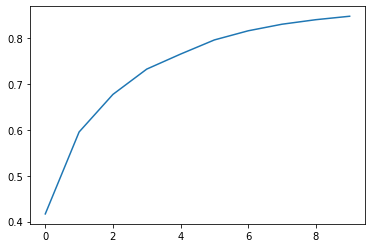

In [78]:
arbre_de_decision(X,y,n_split=10,max_depth=10)

Après la période d'apprentissage, on voit que la meilleure régression est obtenue pour max_depth = 9 et que le r2_score vaut 0.8479813291734217

#### KNeighbors

Dans un deuxième temps, je me suis intéréssé à faire une prédiction avec KNeighbors.

L'hyperparamètre que l'on fait varier est ici max_k

In [74]:
from sklearn.neighbors import KNeighborsRegressor

def KNN_regression(X,y,n_split=10,max_k=20):
    kf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_SEED)
    r2_scores_by_k = []
    for i in range(max_k):
        r2_scores = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            knnreg = KNeighborsRegressor(n_neighbors=i+1)
            knnreg.fit(X_train,y_train)
            y_pred = knnreg.predict(X_test)
            r2_scores.append(r2_score(y_test,y_pred))
        r2_scores_by_k.append(np.mean(r2_scores))
    plt.plot(r2_scores_by_k)
    print("On obtient une meilleure régression avec l'hyperparamètre k =" , np.argmax(r2_scores_by_k))
    return(np.max(r2_scores_by_k))


On obtient une meilleure régression avec l'hyperparamètre k = 1


0.8697737612664579

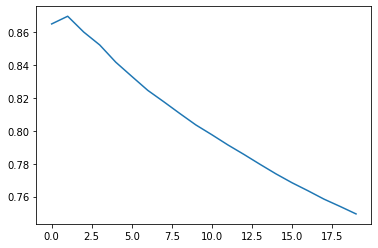

In [75]:
KNN_regression(X,y,n_split=10,max_k=20)

Après la période d'apprentissage, on voit que la meilleure régression est obtenue pour maw_k = 1 et que le r2_score vaut 0.8697737612664579

#### GradientBoosting

Dans un troisième temps, j'ai appliqué un gradient boosting. 

L'hyperparamètre que je fais varier est n_estim

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

def GradBoost_reg(X,y, n_split=10, lr=0.1, n_estim_list = np.array([100, 150, 200,250,300])):
    kf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_SEED)
    scores = np.zeros((len(n_estim_list)))
    for i,n_estim in enumerate(n_estim_list):
        scores_fixed_param = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            reg = GradientBoostingRegressor(random_state=None, n_estimators=n_estim, learning_rate=lr)
            reg.fit(X_train,y_train)
            y_pred = reg.predict(X_test)
            score = r2_score(y_test, y_pred)
            scores_fixed_param.append(score)
        scores[i] = np.mean(np.array(scores_fixed_param))
    plt.plot(n_estim_list, scores)
    return scores

array([0.8052435 , 0.8186914 , 0.82930229, 0.83888313, 0.8478964 ])

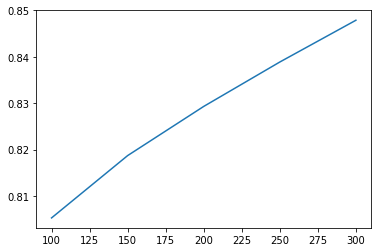

In [23]:
GradBoost_reg(X,y, n_split=10, lr=0.1, n_estim_list = np.array([100, 150, 200,250,300]))

Après la période d'apprentissage, on voit que la meilleure régression est obtenue pour n_estim = 300 et que le r2_score vaut 0.8478964

### SVM

Je fais une regression avec SVM

In [24]:
from sklearn.svm import SVR

def SVM_regression(X,y,kernel = "linear",degree=3,n_split=10):
    kf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_SEED)
    r2_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        if kernel == "poly":
            SVMreg = SVR(kernel="poly", degree=degree)
        else:
            SVMreg = SVR(kernel = kernel)
        SVMreg.fit(X_train,y_train)
        y_pred = SVMreg.predict(X_test)
        r2_scores.append(r2_score(y_test,y_pred))
    return np.mean(r2_scores)


In [ ]:
SVM_regression(X,y,kernel = "linear",degree=3,n_split=10)

Après une execution de 1h sans résultat, j'ai interrompu le run...

#### AdaBoost

Enfin, j'ai voulu faire une prédiction avec AdaBoost. 

Les hyperparamètres que je fais varier sont n_estim et le learning rate lr. 

In [1]:
from sklearn.ensemble import AdaBoostRegressor

def AdaBoost(X, y, n_split=10, loss='linear',random_state=None):
    kf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_SEED)
    n_estim_list = np.array([100, 150, 200])
    lr_list = np.array([0.5, 1.0, 2.0])
    scores = np.zeros((len(n_estim_list), len(lr_list)))
    for i,n_estim in enumerate(n_estim_list):
        for j,lr in enumerate(lr_list):
            for train_index, test_index in kf.split(X):
                scores_fixed_param = []
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                ada_regr = AdaBoostRegressor(random_state=random_state, n_estimators=n_estim, learning_rate=lr)
                ada_regr.fit(X_train,y_train)
                y_pred = ada_regr.predict(X_test)
                score = r2_score(y_test, y_pred)
                scores_fixed_param.append(score)
                
            scores[i][j] = np.mean(scores_fixed_param)
            
    # Figure: 3D plot of score as function of n_estimators and learning_rate
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    n_estims, l_rates = np.meshgrid(n_estim_list, lr)
    surf = ax.plot_surface(n_estims, l_rates, scores)
    plt.xlabel("nb estimators")
    plt.ylabel("learning rate")
    plt.show()
    
    return scores

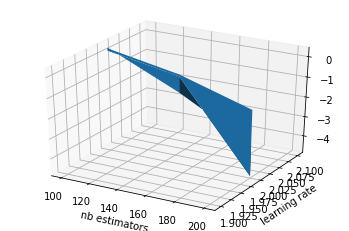

array([[ 0.34537549, -1.235112  , -3.14097873],
       [ 0.1989294 , -0.44439094, -4.76118967],
       [ 0.30655414, -0.34890316, -1.42840813]])

In [73]:
AdaBoost(X, y, n_split=10, loss='linear',random_state=None)

J'obtiens des r2_score supérieurs à 1... Il y a un problème dans le code que je ne comprends pas..